# Mixture of Gaussians

Ok, this model is a universal density approximator, so I wanted to try it out to model the $m_{hh}$ shape.

I want to try training with the EM alg and stochastic methods, because really the goal here is to gain an understanding of the hyperparameters needed to model this appropriately. 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler

import os
import sys
sys.path.append("../../pytorch-flows")
import flows as fnn

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from scipy.stats import entropy, pearsonr, skew, kstest, norm

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGM

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.path.append("../code")
from AnalysisUtils import *

In [3]:
data_fileName = "../../public/hh4b/nanoNtuples/data16/data16_with_weights.root"
df = nanoToDf(data_fileName.format("topo"),ttree='fullmassplane')

fullmassplane


Should I take the log? Let's make a comparison.

In [7]:
mask = (df.kinematic_region == 2) & (df.ntag == 2)
m_hh = df.loc[mask,'m_hh'].values

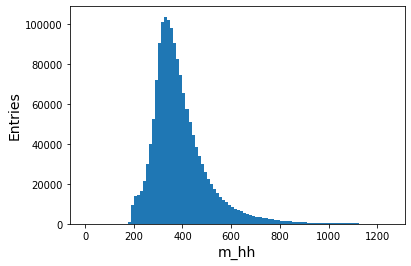

In [15]:
plt.hist(m_hh,100,(0,1250))
plt.xlabel('m_hh',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.show()

In [9]:
np.min(m_hh)

178.4574772514667

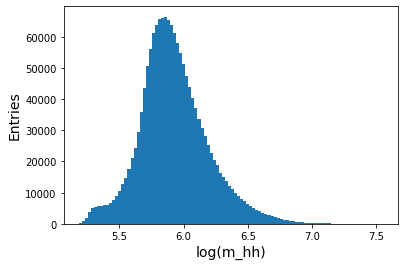

In [16]:
plt.hist(np.log(m_hh),100)#,(0,1250))
plt.xlabel('log(m_hh)',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.show()

From these two plots, I think the log version looks easier to model, but that might be my intuition being faulty tbh. 

In [17]:
np.random.randn(10)

array([ 0.3836892 ,  0.84959269,  1.40481321, -1.35855804,  0.02824558,
        0.39037369,  0.65054694,  0.30192149,  0.38606715, -0.27622636])

Define a class that we can easily tune hyperparameters with.

Ok, so I covered MoG and the EM alg in ML (CS 229) and PGM (CS 228), but neither of these had a solution for the covariance matrix $\Sigma$ in the M-step, but I found it from [these notes](https://www.ics.uci.edu/~smyth/courses/cs274/notes/EMnotes.pdf).


In [198]:
# class MoG():
    
#     def __init__(self, Ntrain=10000, k=1, log=True):
#         '''
#         '''
        
#         # Dataset
#         mask = (df.kinematic_region == 2) & (df.ntag == 2)
#         m_hh = df.loc[mask,'m_hh'].values.reshape(-1, 1)
        
#         # Take the log
#         if log:
#             m_hh = np.log(m_hh)
        
#         # Normalize
#         scalarX = StandardScaler()
#         scalarX.fit(m_hh)
        
#         self.x = scalarX.transform(m_hh,copy=True).reshape(-1,1)
#         self.scalarX = scalarX
        
#         # Initialize the model parameters
#         self.k = k 
        
#         self.phis   = (np.ones(k) / k).reshape(1,k)
#         self.mus    = np.random.randn(k).reshape(1,k)
#         self.sigmas = np.ones(k).reshape(1,k)
        
#         # Save the training parameters - and calculate the first log likelihood
#         self.ps = norm.pdf(self.x, loc=self.mus, scale=self.sigmas) * self.phis
#         self.ws = self.ps / np.sum(self.ps,axis=1).reshape(-1,1)
        
#         l = self.get_likelihood()
        
#         self.elbo = [l]
     
#     def get_likelihood(self):
#         return np.sum(self.ws * np.log(self.ps))
    
#     def EM(self,nIters):
#         '''
#         Fit the MoG moddels using the EM alg
#         '''
#         for i in tqdm(range(nIters)):
#             # M-step: Fit the parameters of each cluster
#             self.phis = np.mean(self.ws, axis=0).reshape(1,self.k)
#             Nk =  np.sum(self.ws,axis=0)
#             if np.min(Nk)  == 0:
#                 print(Nk)
#                 break
#             self.mus = np.sum(self.ws * self.x,axis=0) / Nk
#             self.mus = self.mus.reshape(1,self.k)
#             self.sigmas = np.sum(self.ws * (self.x - self.mus)**2, axis=0) / Nk
#             self.sigmas = self.sigmas.reshape(1,self.k)        
#             # E-step: Find the weight for each training points for each of 
#             #         the different Gaussian modes
#             self.ps = norm.pdf(self.x, loc=self.mus, scale=self.sigmas) * self.phis
#             self.ws = self.ps / np.sum(self.ps,axis=1).reshape(-1,1)
#             l = self.get_likelihood()
#             #l = np.sum(self.ws * np.log(self.ps) - self.ws * np.log(self.ws))
#             self.elbo.append(l)
#             # Check convergence
#             if self.elbo[-1] == self.elbo[-2]:
#                 break
#     def plot(self,title=''):
#         '''
#         Plot m_hh colored by the different components
#         '''
#         plt.hist(self.x,50,color='paleturquoise',density=True)
#         xlim = plt.xlim()
#         x = np.linspace(*xlim,10000)
#         y = np.zeros_like(x)
#         for phi, mu, sigma in zip(self.phis.squeeze(),self.mus.squeeze(),self.sigmas.squeeze()):
#             yi = phi * np.exp(- 0.5 * ((x-mu)/sigma)**2) / (np.sqrt(2*np.pi*sigma))
#             y += yi
#             plt.plot(x,yi)
#         # Overlay the sum as well
#         plt.plot(x,y,'k')
#         plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
#         plt.ylabel('"Normalized" entries',fontsize=14)
#         plt.title
#         plt.show()
        

In [124]:
class MoG():
    
    def __init__(self, Ntrain=10000, log=True, alg='GMM', kargs={'n_components':1}):
        '''
        '''
        
        # Dataset
        mask = (df.kinematic_region == 2) & (df.ntag == 2)
        m_hh = df.loc[mask,'m_hh'].values[:Ntrain].reshape(-1, 1)
        
        # Take the log
        if log:
            m_hh = np.log(m_hh)
        
        # Normalize
        scalarX = StandardScaler()
        scalarX.fit(m_hh)
        
        self.x = scalarX.transform(m_hh,copy=True).reshape(-1,1)
        self.scalarX = scalarX
        
        # Initialize the model parameters
        self.k = kargs['n_components']
        
        # Define the Gaussina mixture model and fit
        if alg == 'GMM':
            self.gmm = GMM(**kargs)
        elif alg == 'BGM':
            self.gmm = BGM(**kargs)
        else:
            print(f'Error: alg {alg} not supported')
            return
        
        self.gmm.fit(self.x)

             

    def plot(self,title=''):
        '''
        Plot m_hh colored by the different components
        '''
        
        plt.hist(self.x,50,color='paleturquoise',density=True)

        phis = self.gmm.weights_
        mus = self.gmm.means_.squeeze()
        sigmas = self.gmm.covariances_.squeeze()

        xlim = plt.xlim()
        xi = np.linspace(*xlim,10000)
        y = np.zeros_like(xi)

        print(phis)
        for phi, mu, sigma in zip(phis, mus, sigmas):

            print(phi,mu,sigma)

            yi = phi * np.exp(- 0.5 * ((xi-mu)/sigma)**2) / (np.sqrt(2*np.pi*sigma))
            y += yi

            plt.plot(xi,yi)

        # And we'll prob want to overlay the sum as well
        plt.plot(xi,y,'k')

        plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
        plt.ylabel('"Normalized" entries',fontsize=14)

        ax = plt.gca()
        plt.text(.975,.975,f"Mixture of Gaussians, k = {self.k}",ha='right',va='top',
                 transform=ax.transAxes,fontsize=14)
        
        plt.show()
        
        

### Try k=1

 25%|██▌       | 1/4 [00:00<00:01,  2.33it/s]


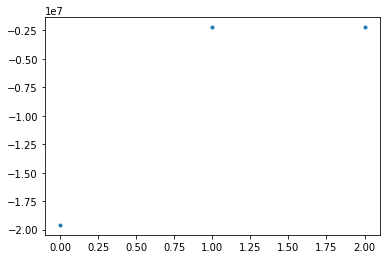

In [149]:
k1 = MoG(k=1)
k1.EM(4)

plt.plot(k1.elbo,'.')
plt.show()

In [150]:
k1.elbo

[-19588604.863712996, -2214327.365869619, -2214327.365869619]

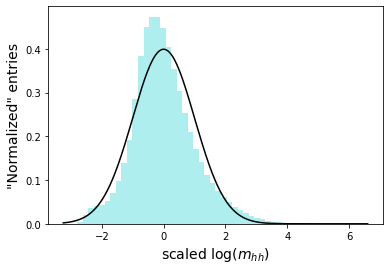

In [151]:
k1.plot()

Ok, so this looks reasonable.

### Try k = 2

 36%|███▋      | 4/11 [00:02<00:03,  1.80it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply
 82%|████████▏ | 9/11 [00:04<00:01,  1.80it/s]


[1560552.       0.]


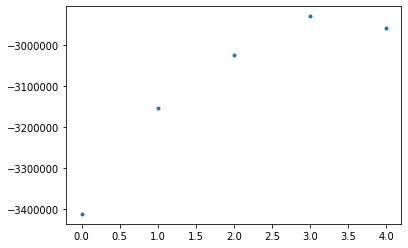

In [199]:
k2 = MoG(k=2)
k2.EM(11)

plt.plot(k2.elbo,'.')
plt.show()

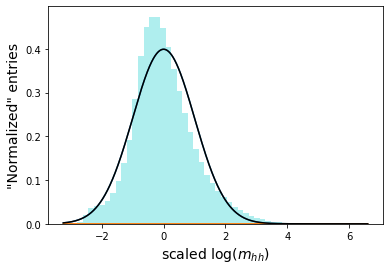

In [205]:
k2.plot()

## Try the sklearn function

**Step 1:** Figure out how many components are needed to model the shape


Initialization 0
  Iteration 10	 time lapse 0.07871s	 ll change 0.00045
Initialization converged: True	 time lapse 0.12735s	 ll -1.39124
0.7077240925015356 -0.27054163675553256 0.5549013203729463
0.292275907498465 0.6550961931670589 1.4713945256732308


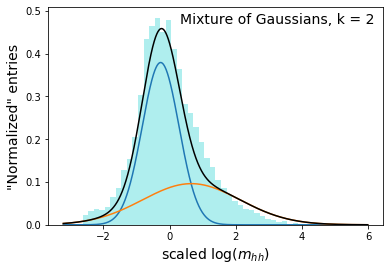

True
Initialization 0
  Iteration 10	 time lapse 0.11328s	 ll change 0.00071
  Iteration 20	 time lapse 0.06163s	 ll change 0.00014
Initialization converged: True	 time lapse 0.20558s	 ll -1.38907
0.2985987004266036 -0.6684620476098786 0.6467691514923506
0.48478979894928 -0.10764305545528373 0.35536159748066765
0.21661150062411674 1.162385899122657 0.9366291836474264


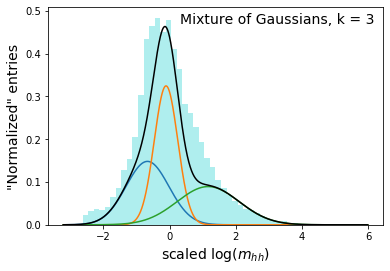

True
Initialization 0
  Iteration 10	 time lapse 0.13864s	 ll change 0.00041
Initialization converged: True	 time lapse 0.21055s	 ll -1.38514
0.15494146966871233 -1.1890334754920096 0.43192665677010766
0.2701947456758431 0.590351076123468 0.2764135994573541
0.4635612717858696 -0.35078874763264745 0.1904517525148612
0.11130251286957418 1.6830968902352843 0.7595610876106699


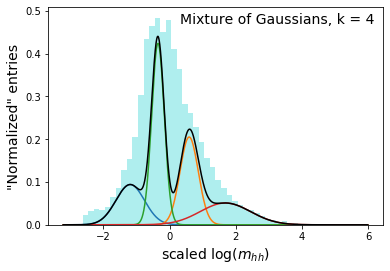

True
Initialization 0
  Iteration 10	 time lapse 0.16951s	 ll change 0.00036
Initialization converged: True	 time lapse 0.25177s	 ll -1.38510
0.1186717082976239 -1.4051632841770334 0.32047702996354877
0.29154336915911233 0.0749997928149883 0.11078710562662245
0.08578908462172484 1.9069698101898285 0.6525956284660925
0.3176471151897324 -0.5797246944596935 0.11191283285234216
0.1863487227318069 0.8877877725349 0.19628045751684617


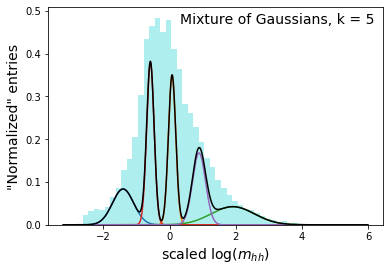

True
Initialization 0
  Iteration 10	 time lapse 0.13180s	 ll change 0.00042
Initialization converged: True	 time lapse 0.23449s	 ll -1.38540
0.19321152405821307 0.4807106126544033 0.10851987139985567
0.2529869837229002 -0.6875579667425389 0.09380602394083971
0.060524699458269694 2.144436433439769 0.5851961062130728
0.10346377396366455 -1.4925793423720062 0.2855899276883017
0.2737624084177125 -0.12659583284811513 0.0814600609733181
0.11605061037923894 1.209455829117251 0.17941142098976032


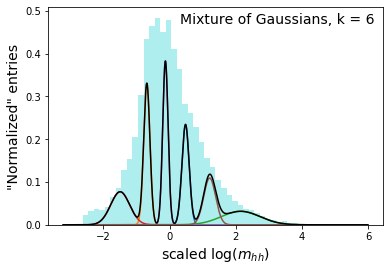

True
Initialization 0
  Iteration 10	 time lapse 0.14958s	 ll change 0.00036
Initialization converged: True	 time lapse 0.25694s	 ll -1.38378
0.25887564310670774 -0.4851497511925239 0.06202869305850776
0.0886504166902989 1.4061156247087299 0.16554740406159998
0.1608304377602552 0.6970578656211674 0.08949234387739631
0.05079611182346562 -1.8547188059868271 0.17896994135576413
0.14381218999031595 -1.0032014386590131 0.10485977922194917
0.048480553754580685 2.288561981456841 0.545393834513519
0.2485546468743754 0.06584847209201355 0.06212326273801431


True
Initialization 0
  Iteration 10	 time lapse 0.11511s	 ll change 0.00033
Initialization converged: True	 time lapse 0.23165s	 ll -1.38295
0.10830724242902218 -1.1825246977873742 0.08185911414169075
0.17095620082031948 0.3493977834637615 0.06129586300942323
0.22680079095155228 -0.616719040728235 0.04771226767658053
0.06554503870297976 1.659016282633083 0.1754541182520631
0.23015166569090956 -0.12835006063631277 0.04874995173173289
0.12723293181448847 0.9348051392656593 0.08946073115991726
0.03685469329879404 -2.0192000376356134 0.12092207088808359
0.034151436291932936 2.4741369686532444 0.5270028742668007


True
Initialization 0
  Iteration 10	 time lapse 0.16103s	 ll change 0.00029
Initialization converged: True	 time lapse 0.23955s	 ll -1.38252
0.20420258591868456 -0.2274422165847388 0.038509322410748864
0.08187755384344335 1.247630887575958 0.07250143097727546
0.1049012717846811 -1.2168379322936846 0.07840797665644234
0.1760894559050696 0.19133283579946783 0.039554238282467874
0.021030049994081118 2.7246358280891068 0.5004428753006895
0.03369489022837366 -2.063190655904363 0.10522949541037431
0.2015593981396322 -0.6609093477152163 0.04112139757186905
0.128446208446027 0.6954879542074711 0.04985603238093912
0.04819858574000657 1.957462619590996 0.16723872800722867


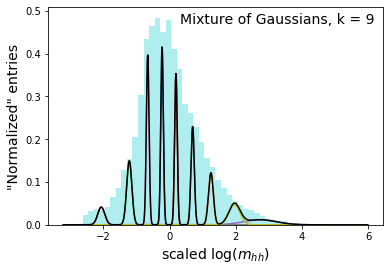

True
Initialization 0
  Iteration 10	 time lapse 0.30293s	 ll change 0.00033
Initialization converged: True	 time lapse 0.44701s	 ll -1.38222
0.14095930988563926 0.25613107815636194 0.030367841807801672
0.02261176128756137 2.676816543301317 0.5172991034206381
0.1266691071853626 -0.8344686451665536 0.037393211751814114
0.027253003065915077 -2.157894535835919 0.07424118934262192
0.08019580090290711 1.2344053521201495 0.06918084285983807
0.17436265887458446 -0.10749051522317721 0.027128051247350096
0.04998367664926022 1.9219710643361718 0.1724254158169401
0.12086177389092068 0.706283022779926 0.04470411175572139
0.17789664971856115 -0.48764120784583576 0.02929652839138073
0.07920625853928676 -1.351571831638446 0.06616602584098454


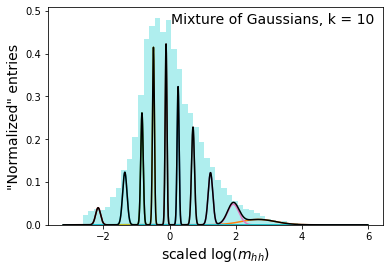

True
Initialization 0
  Iteration 10	 time lapse 0.28776s	 ll change 0.00027
Initialization converged: True	 time lapse 0.40303s	 ll -1.38213
0.16573850385484223 -0.41747610739707985 0.024359929359599797
0.0810755722635456 1.1135144998172015 0.045847639929898314
0.09564002635002326 -1.2724229459308676 0.07201282722044072
0.16049016894173396 -0.06550698486338628 0.021431915810482066
0.029581551785122912 2.3374231807449797 0.12491790912766851
0.030455576142099938 -2.1106166223954568 0.0889514532118634
0.14651079241545786 -0.7590808272312827 0.03146157227234248
0.04891682035665346 1.64585018685321 0.06913581255127983
0.12692954770023238 0.2730669846552048 0.022922209254282674
0.010369399060169258 3.1373932297075853 0.3962391168556225
0.10429204113011759 0.6689570482253153 0.030063306864904462


True


In [84]:
lls = []

kargs = {
    'n_components': 2,
    'verbose': 2,
    'tol': 1e-4
}


for k in range(2,12):

    kargs['n_components'] = k
    m = MoG(kargs=kargs)
    m.plot()
    lls.append(m.gmm.lower_bound_)
    print(m.gmm.converged_)

In [93]:
kargs['n_components'] = 100
kargs['tol'] = 1e-6
kargs['max_iter'] = 750
m = MoG(kargs=kargs)
m.plot()
lls.append(m.gmm.lower_bound_)
print(m.gmm.converged_)

Initialization 0
  Iteration 10	 time lapse 1.14485s	 ll change 0.00020
  Iteration 20	 time lapse 0.88261s	 ll change 0.00005
  Iteration 30	 time lapse 1.00793s	 ll change 0.00005
  Iteration 40	 time lapse 0.94049s	 ll change 0.00003
  Iteration 50	 time lapse 0.92690s	 ll change 0.00003
  Iteration 60	 time lapse 0.81637s	 ll change 0.00003
  Iteration 70	 time lapse 0.79453s	 ll change 0.00002
  Iteration 80	 time lapse 0.77876s	 ll change 0.00001
  Iteration 90	 time lapse 0.77550s	 ll change 0.00001
  Iteration 100	 time lapse 0.88443s	 ll change 0.00001
  Iteration 110	 time lapse 0.98976s	 ll change 0.00001
  Iteration 120	 time lapse 1.11089s	 ll change 0.00000
  Iteration 130	 time lapse 0.86689s	 ll change 0.00000
  Iteration 140	 time lapse 0.89751s	 ll change 0.00000
  Iteration 150	 time lapse 0.82030s	 ll change 0.00000
  Iteration 160	 time lapse 0.78081s	 ll change 0.00000
  Iteration 170	 time lapse 0.80355s	 ll change 0.00000
  Iteration 180	 time lapse 0.78163s	 ll

True


In [94]:
lls

[-1.3912403448677617,
 -1.3890687072376815,
 -1.3851382204685583,
 -1.3850961808407563,
 -1.3854024602653465,
 -1.3837834064918701,
 -1.3829480234979423,
 -1.3825151611136188,
 -1.3822237433678852,
 -1.3821309082701947,
 -1.370918986636471,
 -1.3689517007541876,
 -1.3671535215264048,
 -1.3678859177475657,
 -1.369149913086378,
 -1.3689304142158238,
 -1.3678696423655379,
 -1.3677473646686835]

In [24]:
probs = m.gmm.predict_proba(m.x)
probs.shape

(10000, 4)

In [ ]:
phi

In [80]:
phis = m.gmm.weights_
mus = m.gmm.means_.squeeze()
sigmas = m.gmm.covariances_.squeeze()

N = np.sum(probs)

# plt.hist(m.x,100,color='k',histtype='step',weights=np.ones_like(m.x)/N)

# xlim = plt.xlim()
# xi = np.linspace(*xlim,10000)
# y = np.zeros_like(xi)

for i, (phi, mu, sigma) in enumerate(zip(phis, mus, sigmas)):
    
    c = f"C{i}"
    n,edg,_ = plt.hist(m.x,100,weights=probs[:,i]/N*(xi[-1]-xi[0]),alpha=0.5,color=c)
    
    yi = phi * np.exp(- 0.5 * ((xi-mu)/sigma)**2) / (np.sqrt(2*np.pi*sigma))
    plt.plot(xi,yi,color=c)
    
    x = 0.5*(edg[:-1]+edg[1:])
    mu_fit = np.sum(n*x)/np.sum(n)
    sigma_fit = np.sum(n*(x-mu_fit)**2)/np.sum(n)
    print(mu_fit,mu)
    print(sigma_fit,sigma)
#     y_fit = phi * np.exp(- 0.5 * ((xi-mu_fit)/sigma_fit)**2) / (np.sqrt(2*np.pi*sigma_fit))
#     plt.plot(xi,y_fit,color=c,linestyle='--')
    
plt.show()

-1.1887958371185896 -1.1890334754920096
0.43610467965029115 0.43192665677010766
0.5901339692733885 0.590351076123468
0.28152806506930794 0.2764135994573541
-0.3508422649556839 -0.35078874763264745
0.192729309535691 0.1904517525148612
1.6777070024579062 1.6830968902352843
0.767983476451896 0.7595610876106699


Ok, I'm surprised that the fit converged, it seems to me like the green and orange ones are too narrow!

Ok, even thought it looked wonky, this was the right thing to do (apparently)

In [220]:
gmm.lower_bound_

-1.3976130891745069

In [221]:
gmm.n_iter_

8

In [222]:
gmm.converged_

True

In [232]:
gmm.get_params()


{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 2,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [233]:
gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

I think it would be v nice to have a plot of the log likelihood as a function of the # of components.

**Step 2:** Decide whether it's better to model $\log(m_{hh})$ or $m_{hh}$ directly

**Step 3:** Look at the extrapolation into the CR.

**Summary and next steps:**

## Variational Bayesian Gaussian Mixture

What I was doing above didn't seem to be working... so I'm going to try something new now.


In [5]:
?BGM

Initialization 0
  Iteration 100	 time lapse 0.69921s	 ll change 0.21774
  Iteration 200	 time lapse 0.66736s	 ll change 0.00812
Initialization converged: True	 time lapse 1.71501s	 ll -4709.00108
[0.42853463 0.57146537]
0.4285346346729556 -0.301698363673324 0.2906858547976606
0.5714653653270444 0.22620020410856137 1.4120887363186287


True
-4709.00108469363
Initialization 0
  Iteration 100	 time lapse 1.38688s	 ll change 0.01988
  Iteration 200	 time lapse 1.35915s	 ll change 0.00686
  Iteration 300	 time lapse 1.35958s	 ll change 0.00403
  Iteration 400	 time lapse 1.35812s	 ll change 0.00262
  Iteration 500	 time lapse 1.36762s	 ll change 0.00172
  Iteration 600	 time lapse 1.35027s	 ll change 0.00112
Initialization converged: True	 time lapse 8.53325s	 ll -4700.60117
[0.25072524 0.0921946  0.18622287 0.31612965 0.15472765]
0.2507252407600173 -0.004249515282617703 0.17156084765688218
0.09219459722576005 -1.4967590278894864 0.31899515113143573
0.18622286868036778 1.1109131327800885 1.165820232905598
0.31612964718802256 -0.5654517299964977 0.1626363497011743
0.15472764614583237 0.7164762811297334 0.2699006896102936


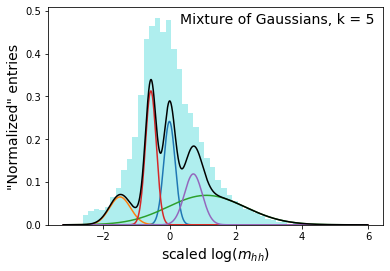

True
-4700.601172187257
Initialization 0
  Iteration 100	 time lapse 2.88684s	 ll change 0.12231
  Iteration 200	 time lapse 2.42755s	 ll change 0.04541
  Iteration 300	 time lapse 2.40523s	 ll change 0.02953
  Iteration 400	 time lapse 2.35507s	 ll change 0.02261
  Iteration 500	 time lapse 2.42696s	 ll change 0.01981
  Iteration 600	 time lapse 2.35495s	 ll change 0.02624
  Iteration 700	 time lapse 2.29346s	 ll change 0.09286
  Iteration 800	 time lapse 2.23603s	 ll change 0.01027
  Iteration 900	 time lapse 2.33861s	 ll change 0.02110
  Iteration 1000	 time lapse 2.23090s	 ll change 0.05428
  Iteration 1100	 time lapse 2.05837s	 ll change 0.01001
  Iteration 1200	 time lapse 2.14562s	 ll change 0.01343
  Iteration 1300	 time lapse 2.43623s	 ll change 0.02715
  Iteration 1400	 time lapse 2.46569s	 ll change 0.00194
  Iteration 1500	 time lapse 2.13061s	 ll change 0.00153
  Iteration 1600	 time lapse 2.33003s	 ll change 0.00129
  Iteration 1700	 time lapse 2.15110s	 ll change 0.00111

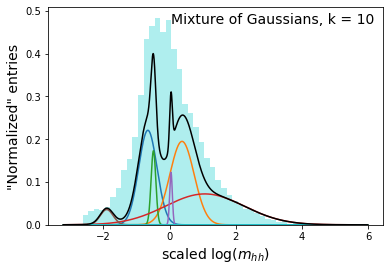

True
-4683.133841753379


In [126]:
kargs = {
    'n_components': 2,
    'verbose': 2,
    #'tol': 1e-3,
    'max_iter': 10000,
    'verbose_interval':100,
    #'weight_concentration_prior_type':'dirichlet_distribution',
    #'weight_concentration_prior': 1
    'covariance_prior' :  np.array(.1).reshape(1,1),
    #'n_init': 10,
    #'init_params':'random'
}


for k in [2,5,10]:

    kargs['n_components'] = k
    m = MoG(alg='BGM',kargs=kargs)
    m.plot()
    print(m.gmm.converged_)
    print(m.gmm.lower_bound_)

In [127]:
m.gmm.weights_

array([2.90787174e-01, 2.95046392e-01, 1.16256115e-01, 1.96956866e-01,
       6.16197454e-02, 3.93237508e-02, 9.05218188e-06, 8.22918904e-07,
       7.48108094e-08, 6.80098268e-09])

In [128]:
m.gmm.covariances_

array([[[0.27620718]],

       [[0.36487811]],

       [[0.07197765]],

       [[1.185874  ]],

       [[0.0402403 ]],

       [[0.1935156 ]],

       [[0.1       ]],

       [[0.1       ]],

       [[0.1       ]],

       [[0.1       ]]])

The smaller covariance prior I choose, the more features I can see in the $m_{hh}$ that it is trying to fit (this is pretty cool tbh).